In [2]:
import pandas as pd

boston = pd.read_csv("../../data/Boston.csv").rename({"Unnamed: 0": "ID"}, axis=1).set_index("ID")
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
ID,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9


In [3]:
boston["dis"].describe()

count    506.000000
mean       3.795043
std        2.105710
min        1.129600
25%        2.100175
50%        3.207450
75%        5.188425
max       12.126500
Name: dis, dtype: float64

In [4]:
from ISLP.models import poly, ModelSpec as MS
import statsmodels.api as sm

def fit_boston(deg):
    X = MS([poly("dis", degree=deg)]).fit_transform(boston)
    Y = boston["nox"]

    results = sm.OLS(Y, X).fit()
    return results

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boston(model, deg, ax=None):
    """
    Plot NOX vs dis with polynomial regression fit.
    """
    if ax is None:
        ax = plt.gca()

    # Prediction grid
    X_pred_grid = np.linspace(boston["dis"].min(), boston["dis"].max(), 200)
    df_grid = pd.DataFrame({"dis": X_pred_grid})

    # Build model spec and transform prediction grid
    spec = MS([poly("dis", degree=deg)])
    spec.fit(boston)
    X_pred = spec.transform(df_grid)

    # Predictions
    Y_pred = model.predict(X_pred)

    # Scatter plot of data
    ax.scatter(boston["dis"], boston["nox"], alpha=0.5, label="Data")

    # Polynomial regression line
    ax.plot(X_pred_grid, Y_pred, c='red', linewidth=2, label=f"Degree {deg}")
    
    ax.set_xlabel("Distance to employment centers (dis)")
    ax.set_ylabel("NOX")
    ax.set_title(f"Polynomial Regression (degree={deg})")
    ax.legend()

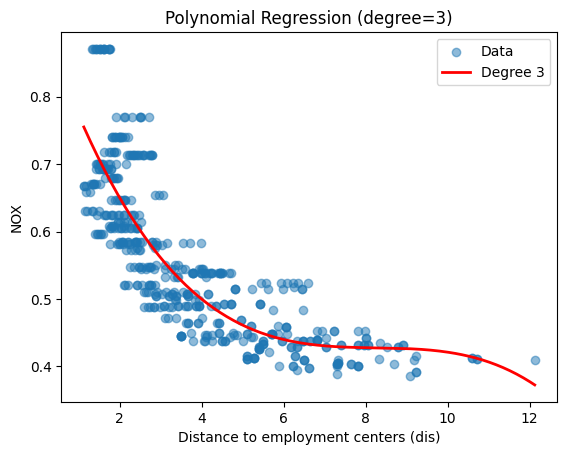

In [6]:
results = fit_boston(deg=3)
plot_boston(results, deg=3)

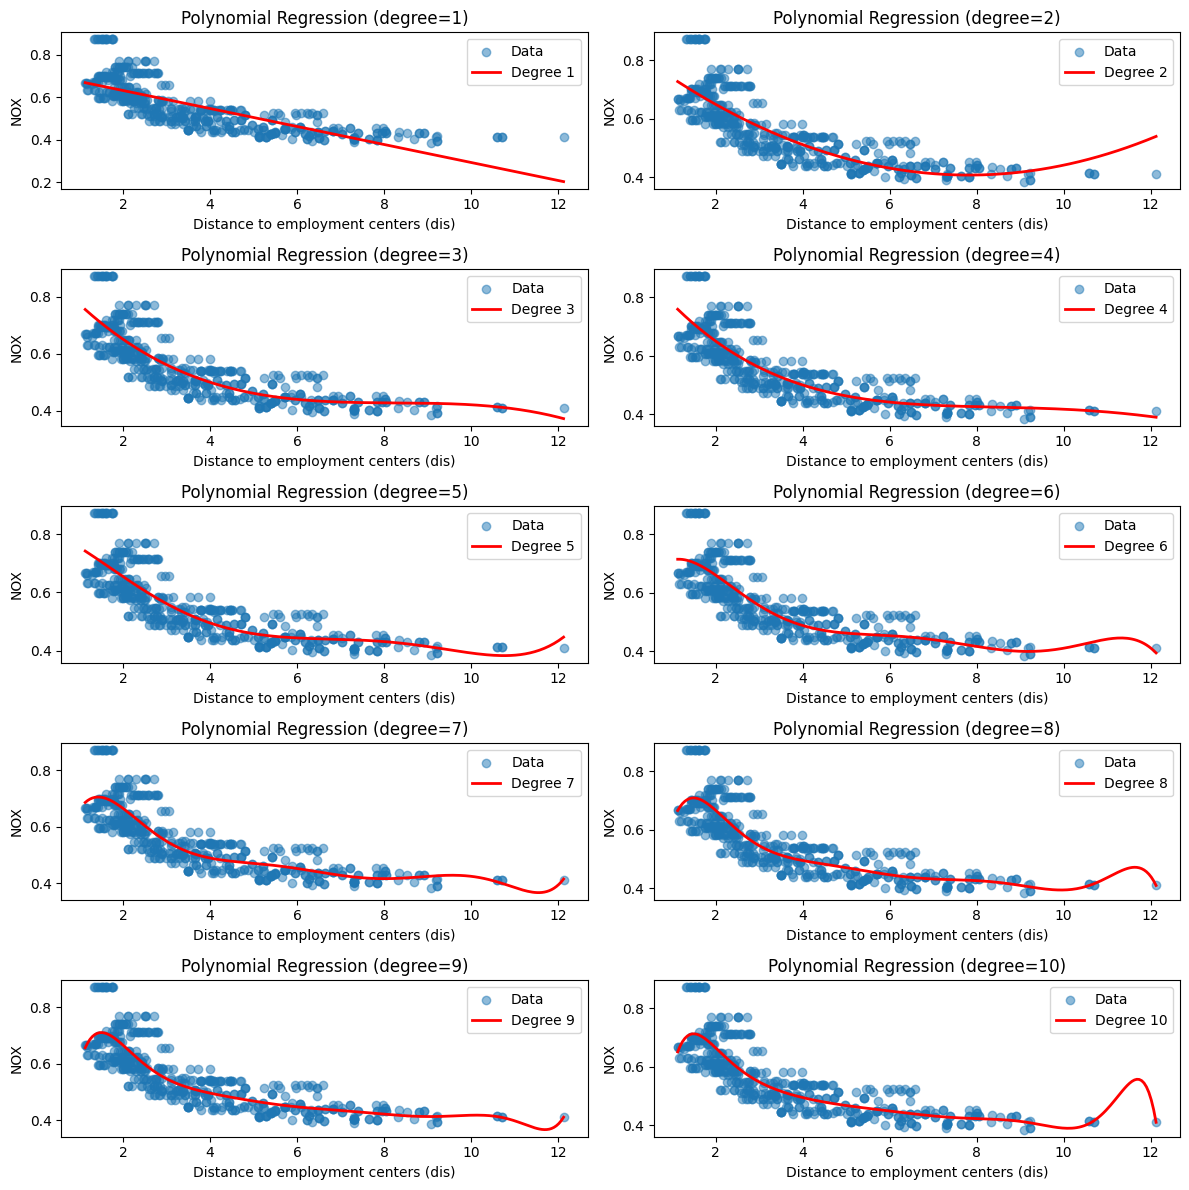

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(1, 11):
    results = fit_boston(deg=i)
    plot_boston(results, i, ax=axes[i-1])

plt.tight_layout()
plt.show()

The key observation is that from degree 3 onwards, the overall shape of the fitted curve stabilizes and consistently captures the general nonlinear decreasing trend of the data. Higher-degree polynomials (degrees 4–10) do not meaningfully improve the fit in the main data range; instead, they mainly introduce unnecessary oscillations at the extremes, where data points are sparse. This happens because polynomials of higher degree have more flexibility, which makes them prone to overfitting at the boundaries—where the model tries to accommodate noise rather than capturing the true underlying pattern.

In [8]:
def plot_boston_rss(model, deg, ax):
    fitted_values = model.fittedvalues
    residuals = model.resid

    ax.scatter(fitted_values, residuals, alpha=0.6, label=f"Degree {deg}")
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    ax.set_title(f"Residuals vs Fitted Values (Degree {deg})")
    ax.legend()
    ax.grid(True)


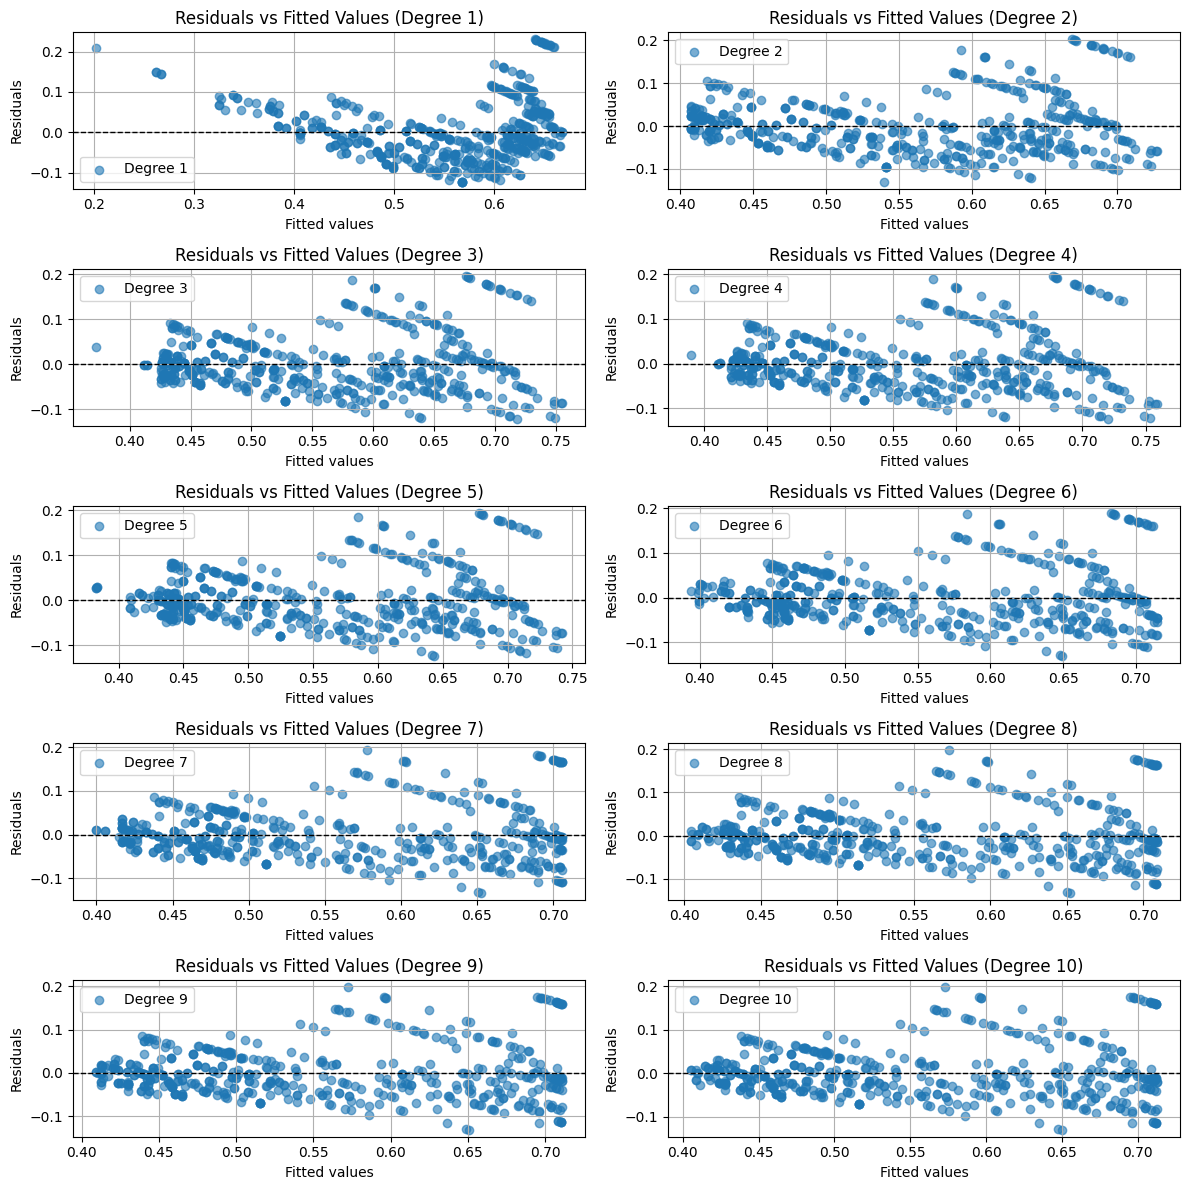

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(1, 11):
    results = fit_boston(deg=i)
    plot_boston_rss(results, i, ax=axes[i-1])

plt.tight_layout()
plt.show()

This pattern is further confirmed by looking at the RSS (residual sum of squares) plots: beyond degree 3, the RSS values remain almost identical across higher-degree models. This indicates that increasing the polynomial degree past 3 does not significantly reduce the overall error, even though the fitted curves become increasingly wiggly at the boundaries.

In [10]:
from ISLP.models import sklearn_sm
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import cross_validate

models = [MS([poly("dis", degree=d)]) for d in range(1, 11)]
X, Y = boston[["dis"]], boston["nox"]

optimal_degree = None
optimal_err = np.inf
cv_errors = []

for degree, model in enumerate(models, start=1):  # start=1 so degree matches polynomial
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    cv_errors.append(cv_err)
    
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_degree = degree

optimal_degree, optimal_err

(3, np.float64(0.004222893611150253))

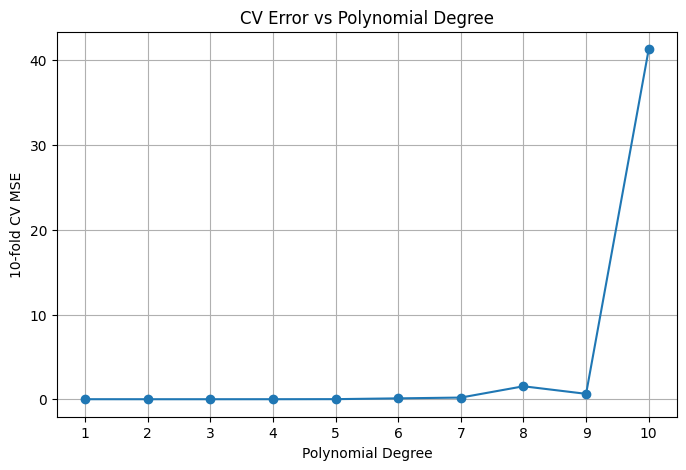

In [11]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), cv_errors, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("10-fold CV MSE")
plt.title("CV Error vs Polynomial Degree")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

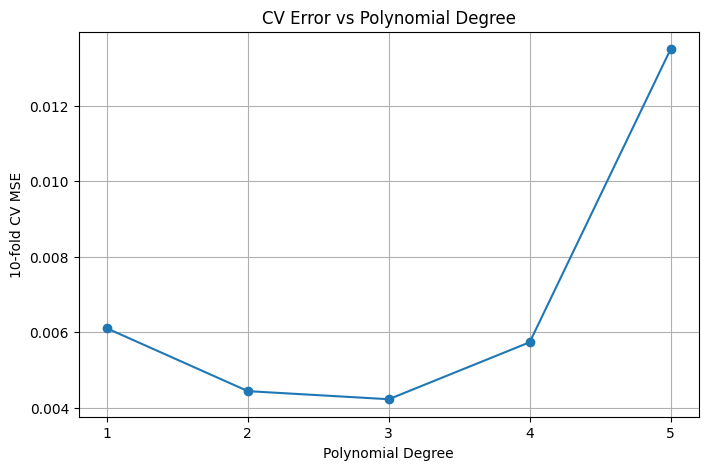

In [12]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 6), cv_errors[0:5], marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("10-fold CV MSE")
plt.title("CV Error vs Polynomial Degree")
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

When we initially plot the cross-validated test errors for all polynomial degrees from 1 to 10, the graph appears almost flat near zero for the lower degrees, with only the 10th-degree model showing a dramatic spike. This makes it seem as if there is little variation in error among the smaller-degree models. However, when we zoom in on the first few degrees, a clearer pattern emerges: the test error decreases from the first-degree model up to the third-degree model, indicating that increasing model complexity initially improves predictive accuracy. Beyond the third degree, however, the test error begins to rise sharply, illustrating overfitting, where the model becomes too flexible and starts to fit the noise in the training data rather than the underlying signal. This pattern highlights the importance of examining lower-degree models closely rather than relying solely on a full-range plot, which can obscure subtle but important trends.

In [13]:
import matplotlib.pyplot as plt

def plot_boston_fit(age_df, basis, title):
    X = basis.transform(boston[['dis']])
    Xnew = basis.transform(age_df)

    M = sm.OLS(boston["nox"], X).fit()

    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(boston["dis"], boston["nox"], facecolor='gray', alpha=0.5)

    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],
                       ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20)
    return ax


In [14]:
from ISLP.models import bs, ns, summarize


bs_dis = MS([bs('dis', internal_knots=[3, 8], degree=2)])
Xbs = bs_dis.fit_transform(boston)
M = sm.OLS(boston["nox"], Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7547,0.012,62.541,0.0
"bs(dis, internal_knots=[3, 8], degree=2)[0]",-0.1293,0.018,-7.324,0.0
"bs(dis, internal_knots=[3, 8], degree=2)[1]",-0.3570,0.014,-25.952,0.0
"bs(dis, internal_knots=[3, 8], degree=2)[2]",-0.3022,0.026,-11.473,0.0
"bs(dis, internal_knots=[3, 8], degree=2)[3]",-0.3737,0.051,-7.353,0.0


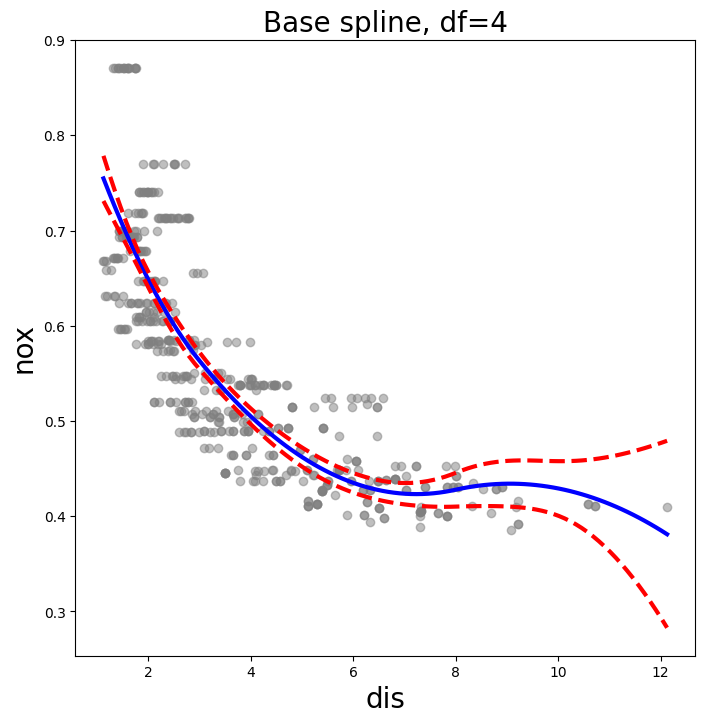

In [15]:
dis_grid = np.linspace(boston["dis"].min(),
                       boston["dis"].max(),
                       100)
dis_df = pd.DataFrame({'dis': dis_grid})

plot_boston_fit(dis_df,
              bs_dis,
              'Base spline, df=4');

Choosing a degree 2 spline with knots at dis = 3 and dis = 8 produces a smoother, less flexible fit compared to a cubic spline, which can better avoid overfitting in smaller datasets. The resulting curve captures the general downward trend of nox as dis increases, reflecting that nitrogen oxide levels decrease with distance from employment centers, but it does so with gentler bends. The knots at 3 and 8 act as points where the slope of the polynomial is allowed to change: the first knot at 3 adjusts the fit in the lower range of dis where the decline is steep, and the second knot at 8 allows the curve to flex slightly in the higher dis range where the data flattens out. Overall, this spline provides a reasonable compromise between flexibility and smoothness, accurately following the main trend while avoiding large swings in regions with sparse data.

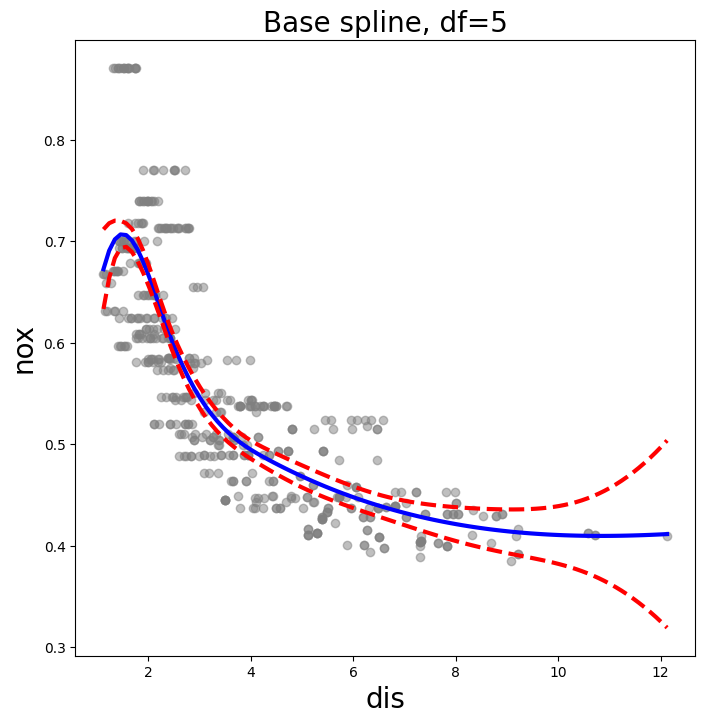

In [16]:
bs_dis = MS([bs('dis', df=5)])
Xbs = bs_dis.fit_transform(boston)
plot_boston_fit(dis_df,
              bs_dis,
              'Base spline, df=5');

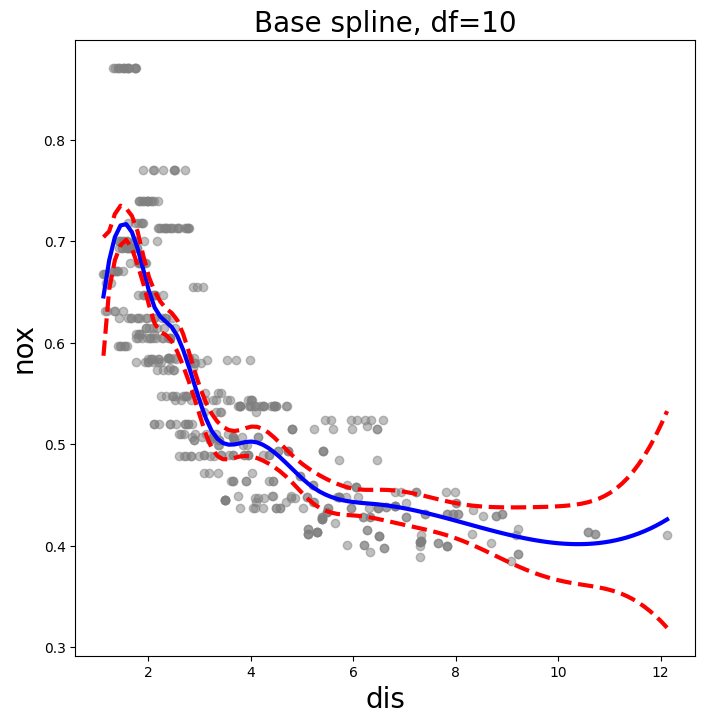

In [17]:
bs_dis = MS([bs('dis', df=10)])
Xbs = bs_dis.fit_transform(boston)
plot_boston_fit(dis_df,
              bs_dis,
              'Base spline, df=10');

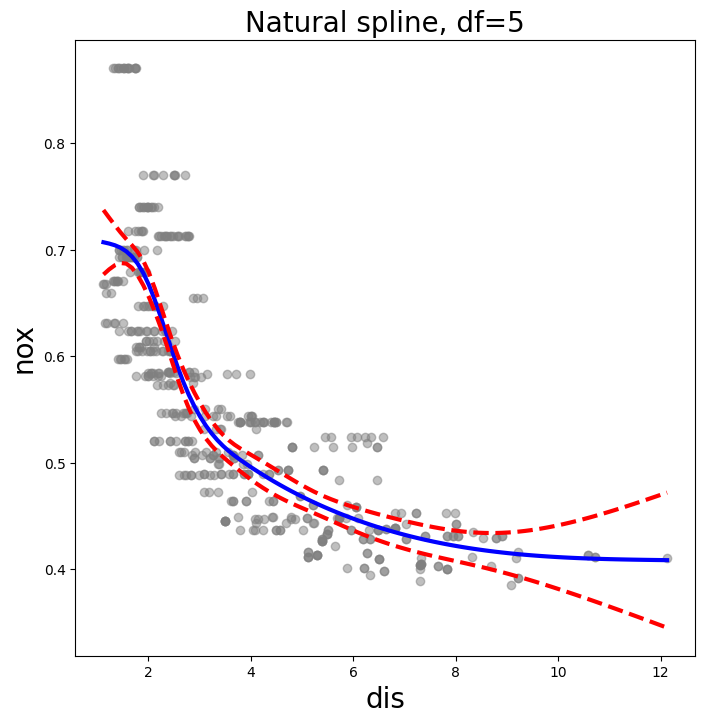

In [18]:
bs_dis = MS([ns('dis', df=5)])
Xbs = bs_dis.fit_transform(boston)
plot_boston_fit(dis_df,
              bs_dis,
              'Natural spline, df=5');

When constructing a spline model, increasing the degrees of freedom (df) allows the curve to bend more freely to fit the data. While this can capture subtle variations in the dataset, adding too much flexibility often makes the graph overly wiggly, introducing artificial oscillations that do not reflect the true underlying trend. This overfitting is particularly noticeable in regions where the data is sparse or exhibits smooth patterns, as the spline tries to pass too closely through every point, creating unnecessary fluctuations.

In practice, these excessive wiggles can distort interpretation, especially at the extremes or in the early values of the dataset. In this case, at the first values, the spline fails to accurately capture the overall trend, deviating from the expected pattern. To address this issue, we can use a natural spline, which constrains the curve to be linear at the boundaries. This boundary behavior prevents extreme bending at the edges, producing a smoother and more realistic fit that better reflects the trend in the initial values while retaining flexibility in the central region of the data.

In [19]:
basis_models = [MS([bs('dis', df=d)]) for d in range(4, 20)]
natural_models =  [MS([ns('dis', df=d)]) for d in range(4, 20)]

optimal_err = np.inf
optimal_df = None

for degree, model in enumerate(basis_models, start=4):
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_df = degree


print("BS: ", optimal_err, optimal_df)

optimal_err = np.inf
optimal_df = None

for degree, model in enumerate(natural_models, start=4):
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_df = degree

print("NS: ", optimal_err, optimal_df)

BS:  0.004683938149463554 6
NS:  0.004756752577215 4


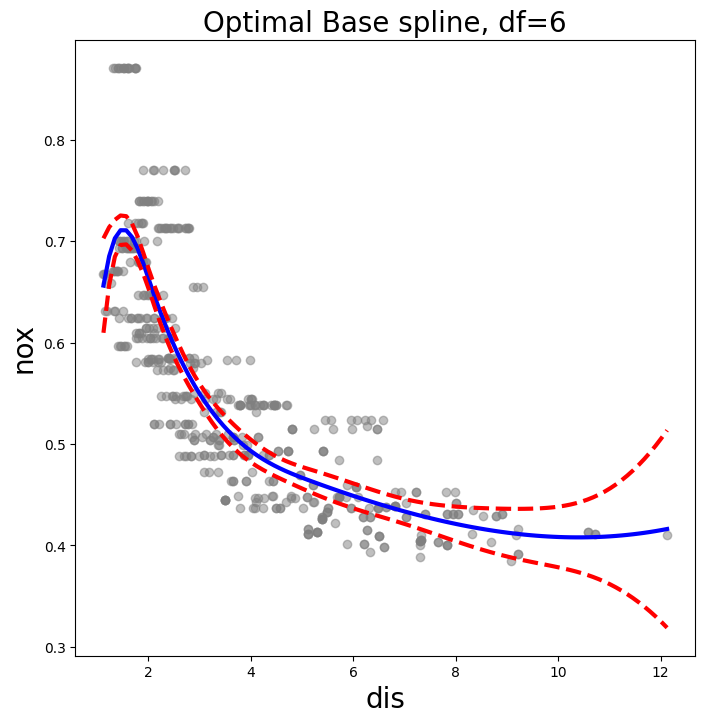

In [20]:
bs_dis = MS([bs('dis', df=6)])
Xbs = bs_dis.fit_transform(boston)
plot_boston_fit(dis_df,
              bs_dis,
              'Optimal Base spline, df=6');

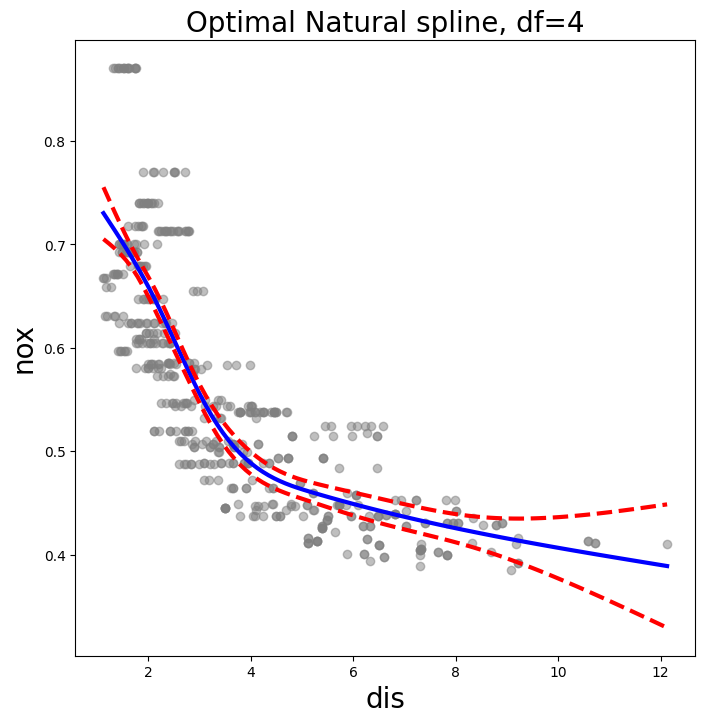

In [21]:
bs_dis = MS([ns('dis', df=4)])
Xbs = bs_dis.fit_transform(boston)
plot_boston_fit(dis_df,
              bs_dis,
              'Optimal Natural spline, df=4');

In our case, the optimal B-spline model achieved a slightly lower cross-validated error of 0.00468 with 6 degrees of freedom, while the optimal natural spline model had a slightly higher error of 0.00476 but with only 4 degrees of freedom. This means that although the B-spline is marginally better in terms of predictive accuracy, the natural spline provides a simpler, more interpretable model due to its lower complexity.

Importantly, the natural spline performed much better at the edges of the data, where the B-spline failed to capture the trend. By forcing linearity at the extremes, the natural spline produces a more stable and realistic fit in those regions, addressing the overfitting and instability seen in the B-spline. Therefore, in this case, choosing between B-splines and natural splines depends on whether the priority is slightly lower predictive error or improved interpretability and boundary behavior.